# Predicting Results for the English Premier League


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime as dt
import itertools
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import random
from sklearn.metrics import roc_curve, auc, mean_squared_error
from sklearn.metrics import roc_auc_score
pd.options.mode.chained_assignment = None
%matplotlib inline

## Import Data as Pandas Dataframe

Each observation is a game. Features include:


* Date = Date of game
* HomeTeam
* AwayTeam
* TFHG = Full Time Home Team Goals
* FTAG = Full Time Away Team Goals
* FTR = Full Time Results (Home, Away, Draw)
* HS = Home shots
* AS = Away shots
* HST = Home shots on target
* AST = Away shots on target
* HF = Home Fouls
* AF = Away Fouls
* HC = Home Corners
* AC = Away Corners
* HY = Home Yellow cards
* AY = Away Yellow cards
* HR = Home Red cards
* AR = Away Red cards

In [2]:
#directory with data 
folder='./EPL/' 

#columns selected: goals, shots, target shots, fouls, corners, yellow and red cards for each team
cols = ['Date','HomeTeam','AwayTeam','FTHG','FTAG','FTR','HS','AS','HST','AST','HF','AF','HC','AC', 'HY','AY','HR','AR']

#store data in temporary list
ls = []
for i in range(0,21):
    filename = '20'+str(i).zfill(2)+'-'+str(i+1).zfill(2)+'.csv'          
    ls.append(pd.read_csv(folder +filename))  
    ls[i] = ls[i][cols]
    ls[i]['season'] = i #add season as a column

#turn list into a df
df = pd.concat(ls, ignore_index=True)
df.Date =pd.to_datetime(df.Date, dayfirst=True)

#Show df
print("dataframe shape:", df.shape)
#df.head()

dataframe shape: (7640, 19)


## Feature Selection with Mutual Information

Feature selection says to remove yellow cards for both teams

In [3]:
#mutual info to find factors
X_all= df.copy()
X_all = X_all.drop(['FTR', 'Date','HomeTeam','AwayTeam', 'season'],1).astype('float64')
y_all = df['FTR'].replace(to_replace ={'H': 0, 'D': 2, 'A': 1})
mi = mutual_info_regression(X_all, y_all, random_state = 7)
mi /= np.max(mi)
print(df.columns[np.where(mi == 0)[0]])
#use info from mutual information to filter 
df = df.drop(df.columns[np.where(mi == 0)[0]], axis='columns')

#df.head()

Index(['HC', 'AC'], dtype='object')


## Compute Cummulative Match Statistics

These are the cummulative stats at the start of each match. That is, they are known before the match begins.
* HS = Total Home shots
* AS = Total Away shots
* HST = Total Home shots on target
* AST = Total Away shots on target
* HF = Total Home Fouls
* AF = Total Away Fouls
* HY = Total Home Yellow cards
* AY = Total Away Yellow cards
* HR = Total Home Red cards
* AR = Total Away Red cards
* HGS = Total Home Team Goals Scored
* AGS = Total Away Team Goals Scored
* HGC = Total Home Team Goals Conceded
* AGC = Total Away Team Goals Conceded
* HP = Total Home Team Points 
* AP = Total Away Team Points
* HOR = Odds Ratio of Home Team shot on target based on previous shots
* AOR = Odds Ratio of Away Team shot on target based on previous shots


In [4]:
#Add new columns to df
df = pd.concat([df, pd.DataFrame(columns = ['HGS', 'AGS', 'HGC', 'AGC', 'HP', 'AP', 'HOR', 'AOR', 'HPT', 'APT'])])

#iterate over list of all seasons
seasons = df['season'].unique()
for season in seasons:
    df_season = df.loc[df.season == season]
    df_season['points'] =  "" #will be used to store goals and compute stats
    
    #iterate over list of all teams in that season
    teams = df_season['HomeTeam'].unique() 
    for team in teams:
              
        #account for home games
        home = df_season.loc[df_season['HomeTeam'] == team]  
        home['scored'] = home['FTHG']
        home['conceded'] = home['FTAG']
        home['shots'] = home['HS']
        home['targets'] = home['HST']
        home.points[home.FTHG > home.FTAG] = 3 #win
        home.points[home.FTHG == home.FTAG] = 1 #draw
        home.points[home.FTHG < home.FTAG] = 0 #lose
        home['fouls'] = home['HF']
        home['yellowflags'] = home['HY']
        home['redflags'] = home['HR']

        #account for away games
        away = df_season.loc[df_season['AwayTeam'] == team]
        away['scored'] = away['FTAG']
        away['conceded'] = away['FTHG']
        away['shots'] = away['AS']
        away['targets'] = away['AST']
        away.points[away.FTHG < away.FTAG] = 3 #win
        away.points[away.FTHG == away.FTAG] = 1 #draw
        away.points[away.FTHG > away.FTAG] = 0 #lose
        away['fouls'] = away['HF']
        away['yellowflags'] = away['HY']
        away['redflags'] = away['HR']
        
        #combined home and away results 
        df_team = pd.concat([home, away])
        df_team.sort_values(by = 'Date', inplace = True)

        #compute cummulative stats
        #FTHG and FTAG
        df_team['cum_scored'] = df_team['scored'].cumsum().shift(1).fillna(0)
        df_team['cum_conceded'] = df_team['conceded'].cumsum().shift(1).fillna(0)
        #HST/AST and HS/AS
        df_team['cum_shots'] = df_team['shots'].cumsum().shift(1)
        df_team['cum_targets'] = df_team['targets'].cumsum().shift(1)
        df_team['probability'] = df_team['cum_targets']/df_team['cum_shots'].values
        df_team['odds_ratio'] = (df_team['probability']/(1-df_team['probability'].values)).fillna(0)
        #Points
        df_team['cum_points'] = df_team['points'].cumsum().shift(1).fillna(0)
        df_team['cum_points2'] = df_team['points'].cumsum()
        #Fouls/YellowFlags/RedFlags
        df_team['cum_fouls'] = df_team['fouls'].cumsum().shift(1)
        df_team['cum_yellowflags'] = df_team['yellowflags'].cumsum().shift(1)
        df_team['cum_redflags'] = df_team['redflags'].cumsum().shift(1)
        
        #assign stats to proper home or away columns in df
        #shots and targets
        df.HS[(df_team.HomeTeam == team) & (df.season == season)] = df_team.cum_shots[df_team.HomeTeam == team]
        df.AS[(df_team.AwayTeam == team) & (df.season == season)] = df_team.cum_shots[df_team.AwayTeam == team] 
        df.HST[(df_team.HomeTeam == team) & (df.season == season)] = df_team.cum_targets[df_team.HomeTeam == team]
        df.AST[(df_team.AwayTeam == team) & (df.season == season)] = df_team.cum_targets[df_team.AwayTeam == team] 
        df.HOR[(df_team.HomeTeam == team) & (df.season == season)] = df_team.odds_ratio[df_team.HomeTeam == team]
        df.AOR[(df_team.AwayTeam == team) & (df.season == season)] = df_team.odds_ratio[df_team.AwayTeam == team]
        #scores and conceded
        df.HGS[(df_team.HomeTeam == team) & (df.season == season)] = df_team.cum_scored[df_team.HomeTeam == team]
        df.AGS[(df_team.AwayTeam == team) & (df.season == season)] = df_team.cum_scored[df_team.AwayTeam == team] 
        df.HGC[(df_team.HomeTeam == team) & (df.season == season)] = df_team.cum_conceded[df_team.HomeTeam == team]
        df.AGC[(df_team.AwayTeam == team) & (df.season == season)] = df_team.cum_conceded[df_team.AwayTeam == team]
        #Points
        df.HP[(df_team.HomeTeam == team) & (df.season == season)] = df_team.cum_points[df_team.HomeTeam == team]
        df.AP[(df_team.AwayTeam == team) & (df.season == season)] = df_team.cum_points[df_team.AwayTeam == team]       
        df.HPT[(df_team.HomeTeam == team) & (df.season == season)] = df_team.cum_points2[df_team.HomeTeam == team]
        df.APT[(df_team.AwayTeam == team) & (df.season == season)] = df_team.cum_points2[df_team.AwayTeam == team]
        #Fouls/YellowFlags/RedFlags
        df.HF[(df_team.HomeTeam == team) & (df.season == season)] = df_team.cum_fouls[df_team.HomeTeam == team]
        df.AF[(df_team.AwayTeam == team) & (df.season == season)] = df_team.cum_fouls[df_team.AwayTeam == team] 
        df.HY[(df_team.HomeTeam == team) & (df.season == season)] = df_team.cum_yellowflags[df_team.HomeTeam == team]
        df.AY[(df_team.AwayTeam == team) & (df.season == season)] = df_team.cum_yellowflags[df_team.AwayTeam == team]
        df.HR[(df_team.HomeTeam == team) & (df.season == season)] = df_team.cum_redflags[df_team.HomeTeam == team]
        df.AR[(df_team.AwayTeam == team) & (df.season == season)] = df_team.cum_redflags[df_team.AwayTeam == team]

#Replace a 100% target/shot (odds ratio = Infinity) with a very high value 
df.replace(to_replace = np.inf, value = 1000, inplace = True)
df.replace(to_replace = np.nan, value = 0, inplace = True)
df = df[(df.season != 18) & (df.season != 19)]
df['Goal Diff'] = df['HGS'] - df['AGS']
df['Conc Diff'] = df['HGC'] - df['AGC']
df = df.drop(['FTHG', 'FTAG'],1)
df

,Date,HomeTeam,AwayTeam,FTR,HS,AS,HST,AST,HF,AF,...,HGC,AGC,HP,AP,HOR,AOR,HPT,APT,Goal Diff,Conc Diff
0,2000-08-19,Charlton,Man City,H,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,3,0,0.0,0.0
1,2000-08-19,Chelsea,West Ham,H,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,3,0,0.0,0.0
2,2000-08-19,Coventry,Middlesbrough,A,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0,3,0.0,0.0
3,2000-08-19,Derby,Southampton,D,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,1,1,0.0,0.0
4,2000-08-19,Leeds,Everton,H,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,3,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7635,2021-05-23,Liverpool,Crystal Palace,H,589.0,344.0,209.0,127.0,387.0,422.0,...,42.0,64.0,66.0,44.0,0.550000,0.585253,69,44,25.0,-22.0
7636,2021-05-23,Man City,Everton,H,583.0,392.0,208.0,145.0,385.0,392.0,...,32.0,43.0,83.0,59.0,0.554667,0.587045,86,59,31.0,-11.0
7637,2021-05-23,Sheffield United,Burnley,H,313.0,374.0,96.0,127.0,382.0,377.0,...,63.0,54.0,20.0,39.0,0.442396,0.514170,23,39,-14.0,9.0
7638,2021-05-23,West Ham,Southampton,H,454.0,406.0,158.0,161.0,383.0,431.0,...,47.0,65.0,62.0,43.0,0.533784,0.657143,65,43,12.0,-18.0


## Correlation Matrix of Features

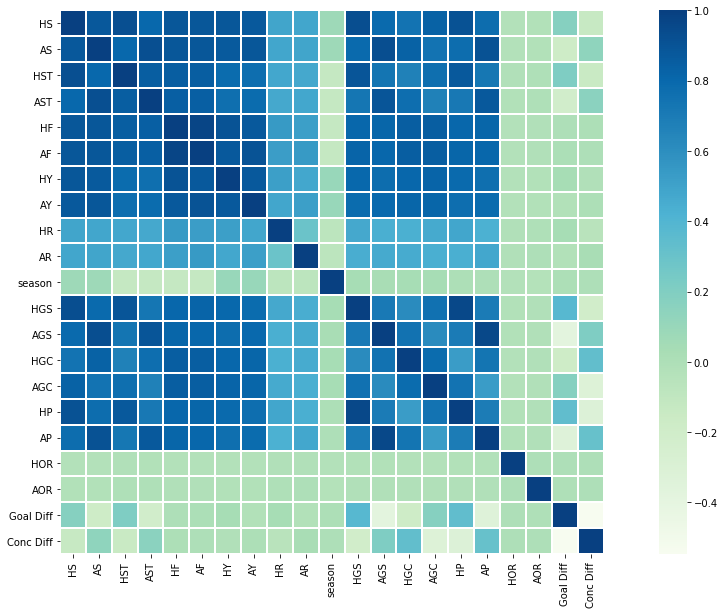

In [5]:
plt.figure(figsize=(20,10)) 
sns.heatmap(df.drop(['HPT', 'APT'], axis = 1).corr(),
                cmap="GnBu",  # Choose a squential colormap
                annot_kws={'fontsize':11},  # Reduce size of label to fit
                fmt='',
                square=True,     # Force square cells
                linewidth=1,  # Add gridlines
                linecolor="white"# Adjust gridline color
               )

# <u>Model for Binary Classifier: Home Win or Not</u>

Home Win is (1), otherwise (0)<br>

Training data is seasons 2000-2016 <br>
Testing data is seasons 2016-2017, 2017-2018 and 2020-2021

In [6]:
#Create binary label for home wins
train1_df = df.drop(['HPT', 'APT'], axis = 1).copy()
train1_df.FTR = train1_df.FTR.replace(to_replace ={'H': 1, 'D': 0, 'A': 0})

#Separate into feature set and target variable
datscatter = train1_df.copy()
X_all = datscatter.drop(['FTR', 'Date','HomeTeam','AwayTeam', 'season'],1).astype('float64')
y_all = datscatter['FTR']

#Split into testing and training set
train = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
test = [16, 17, 20]
X_train, y_train = X_all[df.season.isin(train)], y_all[df.season.isin(train)]
X_test, y_test = X_all[df.season.isin(test)], y_all[df.season.isin(test)]

# Dictionaries used to store MSE, ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
mse = dict()

## Classifiers
We try 8 different classifiers
* Logistic Regression
* SVM Kernel
* Random Forest
* KNN
* QDA
* AdaBoost
* Neural Networks
* Naive Bayes

Random Forest
train
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      3264
           1       0.99      0.96      0.98      2816

    accuracy                           0.98      6080
   macro avg       0.98      0.98      0.98      6080
weighted avg       0.98      0.98      0.98      6080

test
              precision    recall  f1-score   support

           0       0.65      0.75      0.70       636
           1       0.62      0.50      0.55       504

    accuracy                           0.64      1140
   macro avg       0.63      0.63      0.63      1140
weighted avg       0.64      0.64      0.63      1140

KNN
train
              precision    recall  f1-score   support

           0       0.79      0.77      0.78      3264
           1       0.74      0.76      0.75      2816

    accuracy                           0.76      6080
   macro avg       0.76      0.76      0.76      6080
weighted avg       0.76      0.76      

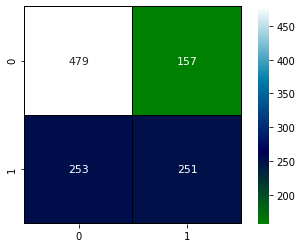

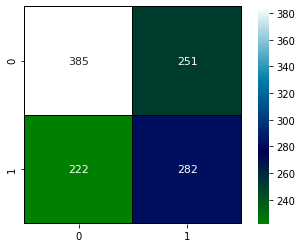

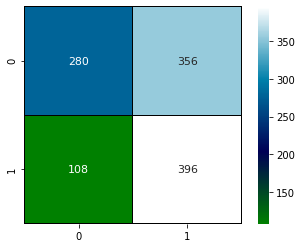

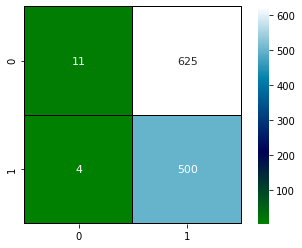

In [7]:
#Create first four models
classifiers1 = [RandomForestClassifier(criterion='gini', 
                             n_estimators=700,
                             min_samples_split=10,
                             min_samples_leaf=1,
                             max_features='auto',
                             oob_score=True,
                             random_state=1,
                             n_jobs=-1),
              KNeighborsClassifier(3),
              MLPClassifier(alpha=1, max_iter=1000),
              GaussianNB()]

names1 = ["Random Forest", "KNN", "Neural Network", "Naive Bayes"]

for classifier, name in zip(classifiers1, names1):
    #Model Training
    classifier.fit(X_train, y_train)
    Y_pred = classifier.predict(X_test)#predicting result
    Y_predtrain = classifier.predict(X_train)#predicting result

    #Create training and testing dictionaries
    mse[name] = dict.fromkeys(['train', 'test'])
    #Compute MSE and micro-average ROC curve and ROC area
    mse[name]['train'] = mean_squared_error(y_train, Y_predtrain)
    mse[name]['test'] = mean_squared_error(y_test, Y_pred)
    fpr[name], tpr[name], _ = roc_curve(y_test.ravel(), Y_pred.ravel())
    roc_auc[name] = auc(fpr[name], tpr[name])

    # Print MSE and Confusion Matrix
    print(name)    
    print('train')
    print(classification_report(y_train, Y_predtrain))
    print('test')
    print(classification_report(y_test, Y_pred))

    cm = confusion_matrix(y_test, Y_pred)
    plt.figure()
    sns.heatmap(cm,
                    cmap="ocean",  # Choose a squential colormap
                    annot_kws={'fontsize':11},  # Reduce size of label to fit
                    fmt='d',
                    annot = True, # Interpret labels as strings
                    square=True,     # Force square cells
                    linewidth=0.1,  # Add gridlines
                    linecolor="k" # Adjust gridline color
                   )

C:\Users\casta\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\casta\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

Logistic
train
              precision    recall  f1-score   support

           0       0.64      0.76      0.69      3264
           1       0.64      0.50      0.56      2816

    accuracy                           0.64      6080
   macro avg       0.64      0.63      0.63      6080
weighted avg       0.64      0.64      0.63      6080

test
              precision    recall  f1-score   support

           0       0.66      0.79      0.72       636
           1       0.65      0.50      0.57       504

    accuracy                           0.66      1140
   macro avg       0.66      0.64      0.64      1140
weighted avg       0.66      0.66      0.65      1140

SVM
train
              precision    recall  f1-score   support

           0       0.63      0.80      0.70      3264
           1       0.65      0.45      0.53      2816

    accuracy                           0.63      6080
   macro avg       0.64      0.62      0.62      6080
weighted avg       0.64      0.63      0.62 

C:\Users\casta\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\casta\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\casta\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


AdaBoost
train
              precision    recall  f1-score   support

           0       0.65      0.76      0.70      3264
           1       0.65      0.53      0.58      2816

    accuracy                           0.65      6080
   macro avg       0.65      0.64      0.64      6080
weighted avg       0.65      0.65      0.64      6080

test
              precision    recall  f1-score   support

           0       0.66      0.73      0.69       636
           1       0.61      0.53      0.57       504

    accuracy                           0.64      1140
   macro avg       0.64      0.63      0.63      1140
weighted avg       0.64      0.64      0.64      1140



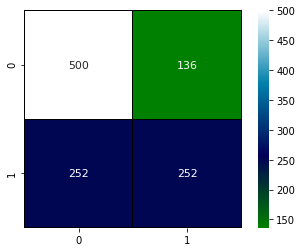

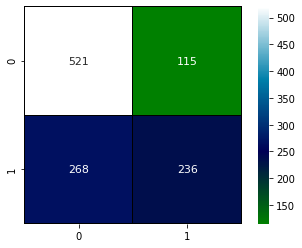

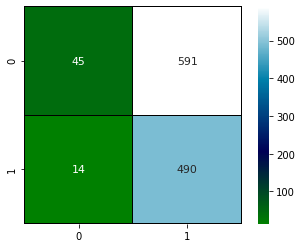

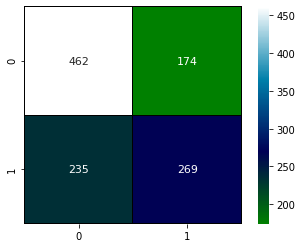

In [8]:
#Create second four models
classifiers2 = [LogisticRegression(random_state = 0),
              SVC(kernel = 'rbf',random_state = 0),
              QuadraticDiscriminantAnalysis(),
              AdaBoostClassifier()]

names2 = ["Logistic", "SVM", "QDA", "AdaBoost"]
for classifier, name in zip(classifiers2, names2):
    #Model Training
    classifier.fit(X_train, y_train)
    Y_pred = classifier.predict(X_test)
    Y_predtrain = classifier.predict(X_train)#predicting result
    y_score = classifier.fit(X_train, y_train).decision_function(X_test) #when finding home win 
    y_scoretrain = classifier.fit(X_train, y_train).decision_function(X_train)
    
    #Create training and testing dictionaries
    mse[name] = dict.fromkeys(['train', 'test'])
    #Compute MSE and micro-average ROC curve and ROC area
    mse[name]['train'] = mean_squared_error(y_train, Y_predtrain)
    mse[name]['test'] = mean_squared_error(y_test, Y_pred)
    fpr[name], tpr[name], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc[name] = auc(fpr[name], tpr[name])

    # Print MSE and Confusion Matrix
    print(name)    
    print('train')
    print(classification_report(y_train, Y_predtrain))
    print('test')
    print(classification_report(y_test, Y_pred))
    
    cm = confusion_matrix(y_test, Y_pred)
    plt.figure()
    sns.heatmap(cm,
                    cmap="ocean",  # Choose a squential colormap
                    annot_kws={'fontsize':11},  # Reduce size of label to fit
                    fmt='d',
                    annot = True, # Interpret labels as strings
                    square=True,     # Force square cells
                    linewidth=0.01,  # Add gridlines
                    linecolor="k"# Adjust gridline color
                   )

In [9]:
mse

{'Random Forest': {'train': 0.022203947368421052, 'test': 0.35964912280701755},
 'KNN': {'train': 0.2355263157894737, 'test': 0.4149122807017544},
 'Neural Network': {'train': 0.42236842105263156, 'test': 0.4070175438596491},
 'Naive Bayes': {'train': 0.5314144736842106, 'test': 0.5517543859649123},
 'Logistic': {'train': 0.3600328947368421, 'test': 0.34035087719298246},
 'SVM': {'train': 0.365625, 'test': 0.33596491228070174},
 'QDA': {'train': 0.5197368421052632, 'test': 0.5307017543859649},
 'AdaBoost': {'train': 0.35098684210526315, 'test': 0.3587719298245614}}

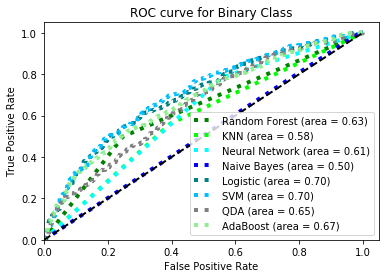

In [10]:
# Plot all ROC curves
plt.figure()
names = ["Random Forest", "KNN", "Neural Network", "Naive Bayes", "Logistic", "SVM", "QDA", "AdaBoost"]
colors = ["green", "lime", "cyan", "blue", "teal", "deepskyblue", "grey", "lightgreen"]
for name, color in zip(names, colors):
    plt.plot(
        fpr[name],
        tpr[name],
        label=name + " (area = {0:0.2f})".format(roc_auc[name]),
        color=color,
        linestyle=":",
        linewidth=4,
    )

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve for Binary Class")
plt.legend(loc="lower right")

# <u>Model for Multiclassifier: Home Win, Away Win, or Draw</u>

Home Win is (0), Away Win is (1), and Draw is (2)<br>

Training data is seasons 2000-2016 <br>
Testing data is seasons 2016-2017, 2017-2018 and 2020-2021

In [11]:
#Multilabels: home = 0, away = 1, draw = 2
train_df = df.drop(['HPT', 'APT'], axis = 1).copy()
train_df.FTR = train_df.FTR.replace(to_replace ={'H': 0, 'D': 2, 'A': 1})

#Separate into feature set and target variable
datscatter = train_df.copy()
X_all = datscatter.drop(['FTR', 'Date','HomeTeam','AwayTeam', 'season'],1).astype('float64')
y_all = datscatter['FTR']

#Split into testing and training set
train = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
test = [16, 17, 20]
X_train2, y_train2 = X_all[df.season.isin(train)], y_all[df.season.isin(train)]
X_test2, y_test2 = X_all[df.season.isin(test)], y_all[df.season.isin(test)]

# Dictionaries used to store ROC curve and ROC area for each class
mse_multi = dict()

## Classifiers
We try 8 different classifiers
* Logistic Regression
* SVM Kernel
* Random Forest
* KNN
* QDA
* AdaBoost
* Neural Networks
* Naive Bayes

Random Forest
train
One-vs-One ROC AUC scores:
0.997602 (macro),
0.997663 (weighted by prevalence)
test
One-vs-One ROC AUC scores:
0.623353 (macro),
0.631999 (weighted by prevalence)
Random Forest
train
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      2816
           1       0.99      0.94      0.96      1696
           2       1.00      0.93      0.97      1568

    accuracy                           0.96      6080
   macro avg       0.97      0.96      0.96      6080
weighted avg       0.97      0.96      0.96      6080

test
              precision    recall  f1-score   support

           0       0.54      0.79      0.64       504
           1       0.50      0.48      0.49       370
           2       0.35      0.06      0.11       266

    accuracy                           0.52      1140
   macro avg       0.46      0.44      0.41      1140
weighted avg       0.48      0.52      0.47      1140

KNN
train
One-vs-One ROC AUC s

C:\Users\casta\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Logistic
train
One-vs-One ROC AUC scores:
0.628963 (macro),
0.635385 (weighted by prevalence)
test
One-vs-One ROC AUC scores:
0.635774 (macro),
0.644720 (weighted by prevalence)
Logistic
train
              precision    recall  f1-score   support

           0       0.53      0.82      0.65      2816
           1       0.45      0.43      0.44      1696
           2       0.32      0.02      0.04      1568

    accuracy                           0.51      6080
   macro avg       0.43      0.42      0.37      6080
weighted avg       0.45      0.51      0.43      6080

test
              precision    recall  f1-score   support

           0       0.54      0.80      0.64       504
           1       0.53      0.52      0.53       370
           2       0.31      0.03      0.06       266

    accuracy                           0.53      1140
   macro avg       0.46      0.45      0.41      1140
weighted avg       0.48      0.53      0.47      1140

SVM
train
One-vs-One ROC AUC scores:
0.6

C:\Users\casta\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\casta\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")



test
              precision    recall  f1-score   support

           0       0.45      0.96      0.62       504
           1       0.60      0.07      0.12       370
           2       0.14      0.02      0.03       266

    accuracy                           0.45      1140
   macro avg       0.40      0.35      0.26      1140
weighted avg       0.43      0.45      0.32      1140

AdaBoost
train
One-vs-One ROC AUC scores:
0.649819 (macro),
0.653815 (weighted by prevalence)
test
One-vs-One ROC AUC scores:
0.610237 (macro),
0.619691 (weighted by prevalence)
AdaBoost
train
              precision    recall  f1-score   support

           0       0.54      0.84      0.65      2816
           1       0.46      0.44      0.45      1696
           2       0.37      0.01      0.03      1568

    accuracy                           0.51      6080
   macro avg       0.46      0.43      0.38      6080
weighted avg       0.47      0.51      0.44      6080

test
              precision    recall 

{'Random Forest': {'train': 0.08240131578947368, 'test': 0.9508771929824561},
 'KNN': {'train': 0.7993421052631579, 'test': 1.2263157894736842},
 'Neural Network': {'train': 1.2922697368421052, 'test': 1.4333333333333333},
 'Naive Bayes': {'train': 1.2578947368421052, 'test': 1.1956140350877194},
 'Logistic': {'train': 1.0577302631578946, 'test': 0.956140350877193},
 'SVM': {'train': 1.1536184210526317, 'test': 1.0640350877192983},
 'QDA': {'train': 1.2620065789473685, 'test': 1.2403508771929825},
 'AdaBoost': {'train': 1.0370065789473684, 'test': 0.9982456140350877}}

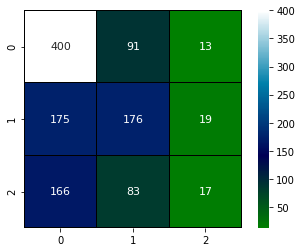

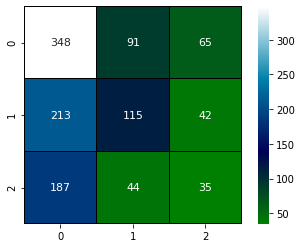

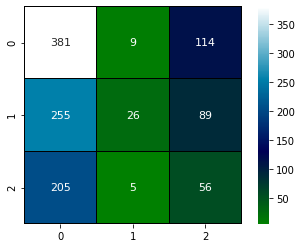

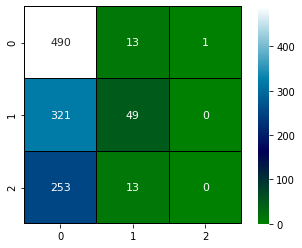

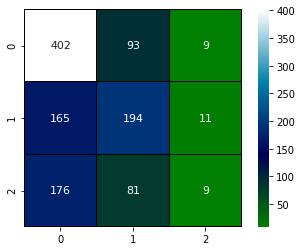

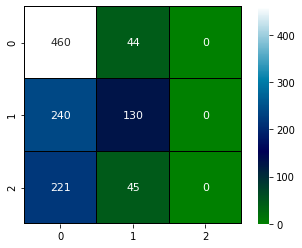

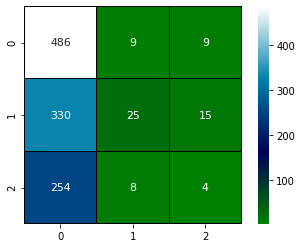

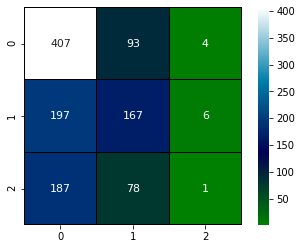

In [12]:
#Create all eight models
classifiers = [RandomForestClassifier(criterion='gini', 
                             n_estimators=700,
                             min_samples_split=10,
                             min_samples_leaf=1,
                             max_features='auto',
                             oob_score=True,
                             random_state=1,
                             n_jobs=-1),
              KNeighborsClassifier(3),
              MLPClassifier(alpha=1, max_iter=1000),
              GaussianNB(),
              LogisticRegression(random_state = 0),
              SVC(kernel = 'rbf',random_state = 0, probability = True),
              QuadraticDiscriminantAnalysis(),
              AdaBoostClassifier()]
    
names = ["Random Forest", "KNN", "Neural Network", "Naive Bayes", "Logistic", "SVM", "QDA", "AdaBoost"]
Y_pred_multi = dict() #store predictions to predict rankings later
for classifier, name in zip(classifiers, names):
    classifier.fit(X_train2, y_train2)
    Y_predtrain2 = classifier.predict(X_train2)#predicting result
    Y_pred_multi[name] = classifier.predict(X_test2)

    # when finding h,w,d
    #TRAINING
    y_probtrain2 = classifier.predict_proba(X_train2)
    macro_roc_auc_ovo_train = roc_auc_score(y_train2, y_probtrain2, multi_class="ovo", average="macro")
    weighted_roc_auc_ovo_train = roc_auc_score(y_train2, y_probtrain2, multi_class="ovo", average="weighted")
    print(name)
    print("train")
    print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} " "(weighted by prevalence)".format(macro_roc_auc_ovo_train, weighted_roc_auc_ovo_train))  
    
    #TESTING
    y_prob2 = classifier.predict_proba(X_test2)
    macro_roc_auc_ovo = roc_auc_score(y_test2, y_prob2, multi_class="ovo", average="macro")
    weighted_roc_auc_ovo = roc_auc_score(y_test2, y_prob2, multi_class="ovo", average="weighted")
    print("test")
    print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} " "(weighted by prevalence)".format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
    
    #Create training and testing dictionaries for MSE
    mse_multi[name] = dict.fromkeys(['train', 'test'])
    #Compute MSE and micro-average ROC curve and ROC area
    mse_multi[name]['train'] = mean_squared_error(y_train2, Y_predtrain2)
    mse_multi[name]['test'] = mean_squared_error(y_test2, Y_pred_multi[name])

    # Print MSE and Confusion Matrix
    print(name)    
    print('train')
    print(classification_report(y_train2, Y_predtrain2))
    print('test')
    print(classification_report(y_test2,Y_pred_multi[name]))

    cm = confusion_matrix(y_test2, Y_pred_multi[name])
    plt.figure()
    sns.heatmap(cm,
                cmap="ocean",  # Choose a squential colormap
                annot_kws={'fontsize':11},  # Reduce size of label to fit
                fmt='d',
                annot = True, # Interpret labels as strings
                square=True,     # Force square cells
                linewidth=0.01,  # Add gridlines
                linecolor="k"# Adjust gridline color
               )
    
print('MSE')
mse_multi

## Compute Premier League Point Totals

### Points
For multiclassifier, we can compute the total points for each team and acquire MSE. Compute for the testing dataset seasons 2017-2021

In [13]:
names = ["Random Forest", "KNN", "Neural Network", "Naive Bayes", "Logistic", "SVM", "QDA", "AdaBoost"]
test = [16, 17, 20]
df2 = df[df.season.isin(test)].reset_index()
df2 = pd.concat([df2, pd.DataFrame.from_dict(Y_pred_multi)], axis = 1)
points = dict()
#iterate over testing seasons
for season in df2['season'].unique():
    df_season = df2.loc[df2.season == season]
    df_season['points'] =  "" #will be used to store goals and compute stats
    df_points = pd.DataFrame(columns = ['Team', 'True Points'] + names ) #store rankings for a given season
    
    #iterate over list of all teams in that season
    teams = df_season['HomeTeam'].unique() 
    df_points['Team'] = teams #store teams in rankings df
    for team in teams:
        #Account for home and away team
        home = df_season.loc[df_season['HomeTeam'] == team]
        away = df_season.loc[df_season['AwayTeam'] == team]  
        
        #Determining True Point Value
        df_team_true = pd.concat([home, away])
        last_game = df_team_true[df_team_true.Date == df_team_true.Date.max()]        
        if list(last_game.iloc[0, 2:4]).index(team) == 0: #If team is HomeTeam on last game then it has index 0 
            df_points['True Points'][df_points.Team == team] = int(last_game['HPT'])
        else: #If team is AwayTeam on last game then it has index 1 
            df_points['True Points'][df_points.Team == team] = int(last_game['APT'])
        
        #Iterate over models
        for model in names:     
            #account for home games
            home.points[home[model] == 0] = 3 #win
            home.points[home[model] == 2] = 1 #draw
            home.points[home[model] == 1] = 0 #lose

            #account for away games
            away.points[away[model] == 1] = 3 #win
            away.points[away[model] == 2] = 1 #draw
            away.points[away[model] == 0] = 0 #lose

            #combined home and away results 
            df_team = pd.concat([home, away])
            df_team.sort_values(by = 'Date', inplace = True)

            #compute cummulative points
            df_points[model][df_points.Team == team] = df_team['points'].cumsum().max()
      
    df_points.sort_values(by = 'True Points', ascending = False, inplace = True, ignore_index = True)
    points[season] = df_points
    
points[20]

,Team,True Points,Random Forest,KNN,Neural Network,Naive Bayes,Logistic,SVM,QDA,AdaBoost
0,Man City,86,84,66,60,75,84,87,58,90
1,Man United,74,76,73,64,63,76,78,62,72
2,Liverpool,69,96,77,67,63,90,96,64,72
3,Chelsea,67,84,66,58,57,92,75,63,93
4,Leicester,66,75,43,58,60,79,63,55,78
5,West Ham,65,70,51,54,60,63,69,55,66
6,Tottenham,62,89,53,70,57,84,51,49,96
7,Arsenal,61,55,49,47,60,57,54,60,69
8,Everton,59,65,53,56,57,65,60,57,63
9,Leeds,59,66,68,53,57,67,72,58,66


{16.0: {'Random Forest': 137.9,
  'KNN': 102.6,
  'Neural Network': 157.4,
  'Naive Bayes': 130.7,
  'Logistic': 209.3,
  'SVM': 84.2,
  'QDA': 303.05,
  'AdaBoost': 109.15},
 17.0: {'Random Forest': 157.55,
  'KNN': 157.0,
  'Neural Network': 112.55,
  'Naive Bayes': 97.9,
  'Logistic': 202.45,
  'SVM': 97.35,
  'QDA': 232.35,
  'AdaBoost': 110.8},
 20.0: {'Random Forest': 203.9,
  'KNN': 158.0,
  'Neural Network': 168.1,
  'Naive Bayes': 162.45,
  'Logistic': 223.2,
  'SVM': 122.85,
  'QDA': 234.9,
  'AdaBoost': 161.9}}

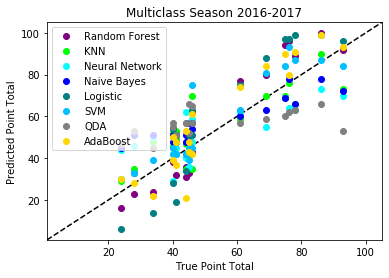

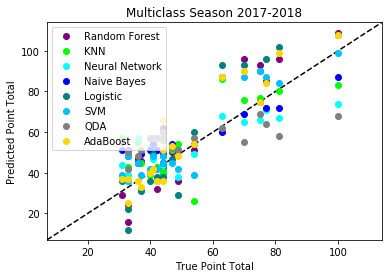

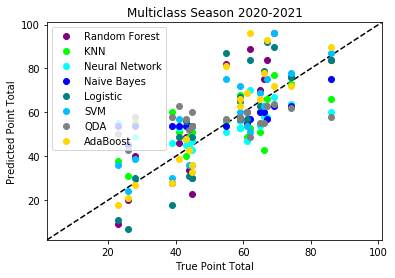

In [14]:
names = ["Random Forest", "KNN", "Neural Network", "Naive Bayes", "Logistic", "SVM", "QDA", "AdaBoost"]
colors = ["purple", "lime", "cyan", "blue", "teal", "deepskyblue", "grey", "gold"]
mse_points = dict()
for key in points:
    mse_points[key] = dict()
    #create a figure for each season tested
    plt.figure()
    min_val = min(points[key].iloc[:,1::].min()) - 5
    max_val = max(points[key].iloc[:,1::].max()) + 5
    plt.xlim(min_val, max_val)
    plt.ylim(min_val, max_val)
    plt.xlabel('True Point Total')
    plt.ylabel('Predicted Point Total') 
    plt.title('Multiclass Season 20' + str(int(key)) + '-20' + str(int(key+1)))
    plt.plot([min_val, max_val], [min_val, max_val], "k--")
    #plot each model
    x = list(points[key]['True Points']) #x axis is True Points 
    for name, color in zip(names, colors):
        y = list(points[key][name]) #Y axis is model Points
        plt.plot(x, y, marker='o', lw = 0, color=color, label = name)
        mse_points[key][name] = mean_squared_error(x, y)
    plt.legend(loc = 'upper left')
    
mse_points

In [15]:
season16_avg = pd.concat([points[16].iloc[:,0:2], points[16].iloc[:,2::].mean(axis = 1)], axis = 1)
season16_avg

,Team,True Points,0
0,Chelsea,93,79.125
1,Tottenham,86,86.500
2,Man City,78,78.000
3,Liverpool,76,80.750
4,Arsenal,75,79.125
5,Man United,69,72.500
6,Everton,61,65.875
7,Southampton,46,64.000
8,Bournemouth,46,46.875
9,West Brom,45,48.750


In [16]:
season17_avg = pd.concat([points[17].iloc[:,0:2], points[17].iloc[:,2::].mean(axis = 1)], axis = 1)
season17_avg

,Team,True Points,0
0,Man City,100,92.000
1,Man United,81,82.250
2,Tottenham,77,78.875
3,Liverpool,75,79.375
4,Chelsea,70,78.875
5,Arsenal,63,78.750
6,Burnley,54,48.750
7,Everton,49,43.625
8,Leicester,47,50.500
9,Bournemouth,44,46.625


In [17]:
season20_avg = pd.concat([points[20].iloc[:,0:2], points[20].iloc[:,2::].mean(axis = 1)], axis = 1)
season20_avg

,Team,True Points,0
0,Man City,86,75.500
1,Man United,74,70.500
2,Liverpool,69,78.125
3,Chelsea,67,73.500
4,Leicester,66,63.875
5,West Ham,65,61.000
6,Tottenham,62,68.625
7,Arsenal,61,56.375
8,Everton,59,59.500
9,Leeds,59,63.375
